In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 43.9 MB/s eta 0:00:00


In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=50df9161df4b275e1240377734a51f2a3f1cbd915e36a765d94e880ac9ad9f24
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
import faiss
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split


## Вам дан DataFrame с новостями (там есть заголовки и краткое содержание)

In [ ]:
df = []
with open('News_Category_Dataset_v3.json') as f:
    for line in tqdm(f):
        df.append(json.loads(line))

df = pd.DataFrame(df)


209527it [00:01, 177577.37it/s]


In [ ]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Новости разбиты на несколько категорий (Посмотрите, на какие)

Мы с вами попробуем поисследовать, как можно искать "близкие" тексты и как это делать более или менее эффективно.
Сначала надо научиться переводить тексты в векторное представление - эмбеддинги.

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens', device = 'cuda')

.gitattributes:   0%|          | 0.00/391 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

# Сразу поделим выборку на "тест и контроль"

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(209527, 6)

In [ ]:
train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['category'])

In [ ]:
train.shape

(167621, 6)

In [ ]:
test.shape

(41906, 6)

In [ ]:
train[train.category == 'CRIME'].shape , test[test.category == 'CRIME'].shape

((2850, 6), (712, 6))

Я гарантировал, что и в тесте и в контроле каждая категория побилась 80 на 20

In [ ]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


# Делаем эмбеддинги

## Задание 1

* Сделайте эмбеддинги заголовков (код в ячейке ниже) и эмбеддинги краткого содержания новостей (другое поле)

Эмбеддинги варятся долго и получаются довольно толстыми. Например, для поля headline список эмбеддингов у меня локально варился 2 часа, а записанный в numpy-файл, весил 500 Мб

In [ ]:
%%time
headline_embeddings = model.encode(train.headline.to_numpy(),
                                   batch_size = 64,
                                   show_progress_bar = True)

Batches:   0%|          | 0/2620 [00:00<?, ?it/s]

CPU times: user 3min 19s, sys: 1.75 s, total: 3min 21s
Wall time: 3min 20s


In [ ]:
shortdesc_embeddings = model.encode(train.short_description.to_numpy(),
                                   batch_size = 64,
                                   show_progress_bar = True)

Batches:   0%|          | 0/2620 [00:00<?, ?it/s]

In [ ]:
import time

## Задание 2

В лекции я утверждал, что "поиск" по "более умному" индексу занимает меньше времени. Возьмите случайую подвыборку из 1000 заголовков из группы test и оцените распределение скорости поиска 10 ближайших соседей по следующим типам индексов, построенных на группе train:

* **IndexFlatL2**
* **IndexIVFFlat** c количеством ячеек ~ sqrt(длина выборки)
* **IndexIVFPQ** с теми же параметрами как в **IndexIVFFlat** и m = bits = 8 (как в лекции)

Ответом будут 3 гистограммы скорости поиска (для каждого индекса по 1)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

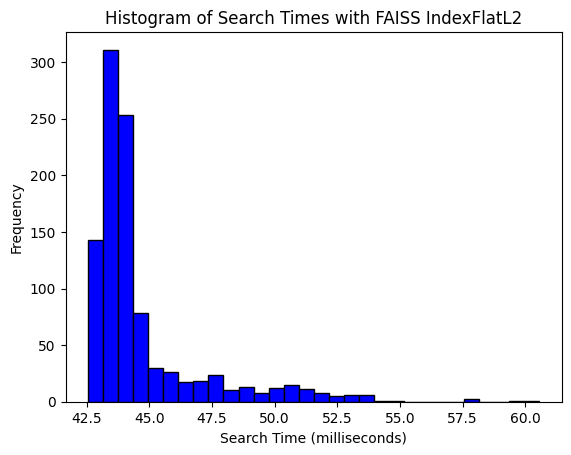

In [ ]:
# Инициализация FAISS индекса
d = headline_embeddings.shape[1]  # Размерность эмбеддингов
index = faiss.IndexFlatL2(d)  # Индекс для L2 расстояния
index.add(headline_embeddings)  # Добавление векторов в индекс

# Выбор случайной подвыборки из 1000 заголовков из тестовой выборки
sample_test = test.sample(n=1000, random_state=42)
headline_embeddings_test = model.encode(sample_test.headline.to_numpy(), batch_size=64, show_progress_bar=True)

# Оценка скорости поиска
search_times = []
k = 10  # Поиск 10 ближайших соседей

for i in range(headline_embeddings_test.shape[0]):
    start_time = time.time()
    index.search(np.array([headline_embeddings_test[i]]), k)
    search_times.append((time.time() - start_time)*1000)


# Построение гистограммы
plt.hist(search_times, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Search Times with FAISS IndexFlatL2')
plt.xlabel('Search Time (milliseconds)')
plt.ylabel('Frequency')
plt.show()

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

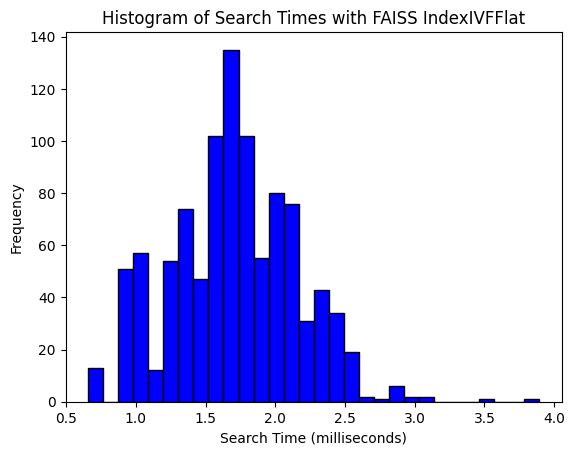

In [ ]:
# Инициализация FAISS индекса
d = headline_embeddings.shape[1]  # Размерность эмбеддингов
quantiser = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantiser, d, int(10*10**0.5),faiss.METRIC_L2)

index.train(headline_embeddings)
index.add(headline_embeddings)  # Добавление векторов в индекс

# Выбор случайной подвыборки из 1000 заголовков из тестовой выборки
sample_test = test.sample(n=1000, random_state=42)
headline_embeddings_test = model.encode(sample_test.headline.to_numpy(), batch_size=64, show_progress_bar=True)

# Оценка скорости поиска
search_times = []
k = 10  # Поиск 10 ближайших соседей

for i in range(headline_embeddings_test.shape[0]):
    start_time = time.time()
    index.search(np.array([headline_embeddings_test[i]]), k)
    search_times.append((time.time() - start_time)*1000)


# Построение гистограммы
plt.hist(search_times, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Search Times with FAISS IndexIVFFlat')
plt.xlabel('Search Time (milliseconds)')
plt.ylabel('Frequency')
plt.show()

Batches:   0%|          | 0/655 [00:00<?, ?it/s]

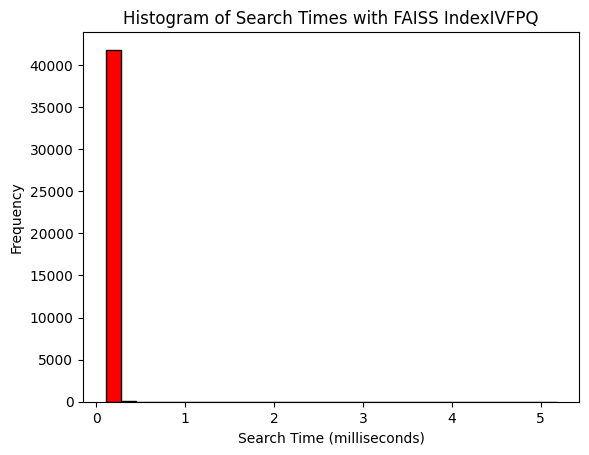

In [ ]:
# Инициализация параметров для IndexIVFPQ
d = headline_embeddings.shape[1]  # Размерность эмбеддингов
nlist = int(np.sqrt(len(headline_embeddings)))  # Количество ячеек для IndexIVFPQ
m = 8  # Количество бит на ячейку (количество квантизаторов)

quantizer = faiss.IndexFlatL2(d)  # Квантайзер для IndexIVFPQ
index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)

# Обучение индекса
index_ivfpq.train(headline_embeddings)
index_ivfpq.add(headline_embeddings)

# Создание эмбеддингов для тестовой выборки
# Предполагаем, что модель для создания эмбеддингов уже загружена
headline_embeddings_test = model.encode(test.headline.to_numpy(), batch_size=64, show_progress_bar=True)

# Оценка скорости поиска с использованием IndexIVFPQ
search_times_ivfpq = []
k = 10  # Поиск 10 ближайших соседей

for i in range(headline_embeddings_test.shape[0]):
    start_time = time.time()
    index_ivfpq.search(np.array([headline_embeddings_test[i]]), k)
    search_times_ivfpq.append((time.time() - start_time)*1000)

# Построение гистограммы
plt.hist(search_times_ivfpq, bins=30, color='red', edgecolor='black')
plt.title('Histogram of Search Times with FAISS IndexIVFPQ')
plt.xlabel('Search Time (milliseconds)')
plt.ylabel('Frequency')
plt.show()


## Задание 3

Возьмите построенные в задании 1 эмбеддинги краткого содержания новостей и сделайте **IndexIVFPQ** с теми же параметрами, как в задании 2, но только по краткому содержанию новостей.

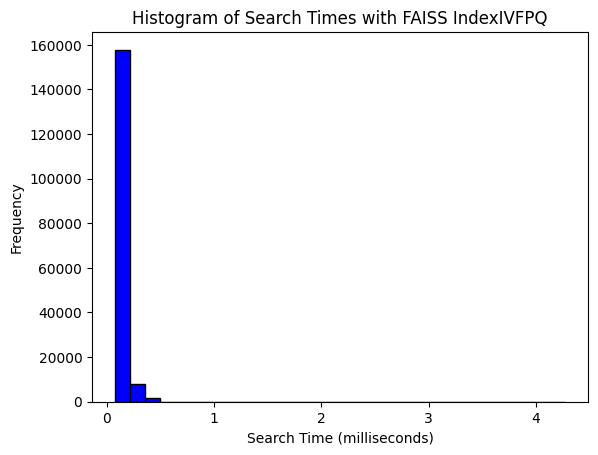

In [ ]:
# Инициализация FAISS индекса
d = shortdesc_embeddings.shape[1]  # Размерность эмбеддингов
quantiser = faiss.IndexFlatL2(d)
index = faiss.IndexIVFPQ(quantiser, d, int(10*10**0.5),8,8)

index.train(shortdesc_embeddings)
index.add(shortdesc_embeddings)  # Добавление векторов в индекс



# Оценка скорости поиска
search_times4_short_desc = []
k = 10  # Поиск 10 ближайших соседей

for i in range(shortdesc_embeddings.shape[0]):
    start_time = time.time()
    index.search(np.array([shortdesc_embeddings[i]]), k)
    search_times4_short_desc.append((time.time() - start_time)*1000)


# Построение гистограммы
plt.hist(search_times4_short_desc, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Search Times with FAISS IndexIVFPQ')
plt.xlabel('Search Time (milliseconds)')
plt.ylabel('Frequency')
plt.show()

## Задание 4

Возьмите из группы test по 100 строк из каждой тематики новостей. Далее, если будете искать в индексе по заголовкам (как в задании 2), используйте заголовок новости, если будете искать в индексе по краткому содержанию (задание 3), то используйте краткое содержание.

**Вопрос**: Как много среди ближайших соседей в индексе новостей С ТОЙ ЖЕ ТЕМАТИКОЙ?

**Как на него ответить**: Разберем на примере COMEDY. Вы взяли 100 текстов из группы test с темой COMEDY. Сгенерируйте их эмбеддинги и для каждой из новостей найдите 10 ближайших соседей в индексе по заголовкам и в индексе по краткому содержанию. По полученным ближайшим соседям посчитайте, у скольких из соседей тема ТОЖЕ COMEDY.
Так вы получите 100 чисел для индекса по заголовкам и 100 чисел для индекса по краткому содержанию.

Ответом будут 2 гистограммы для каждой из тематик.
Понятно ли, почему гистограммы вышли именно такие как вышли?


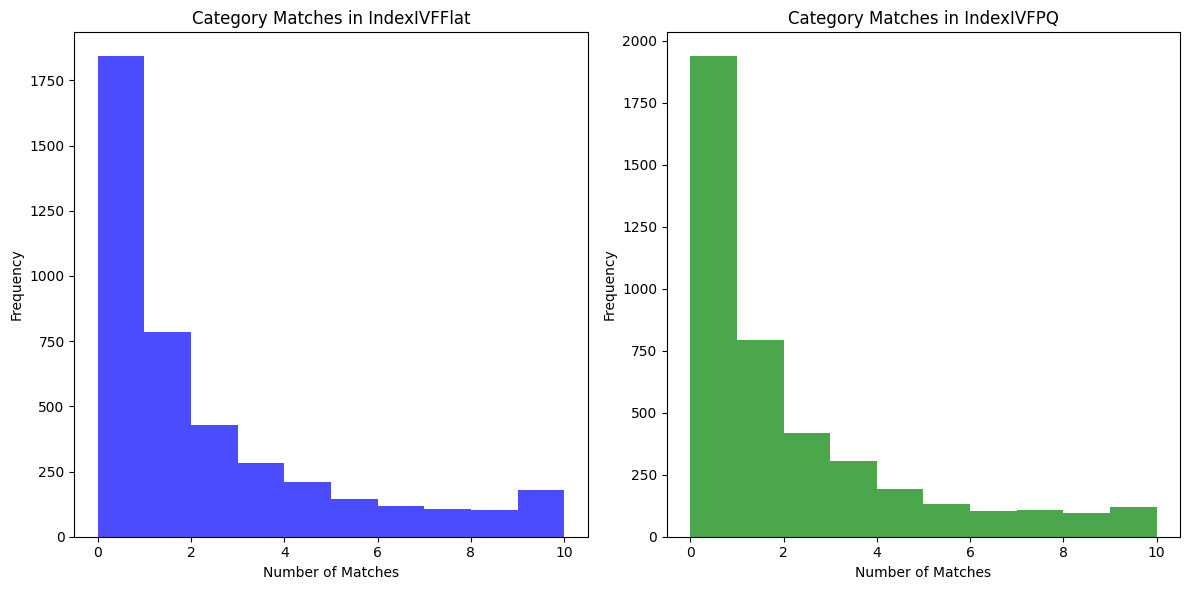

In [ ]:
# Выбор по одной строке из каждой тематики новостей в тестовой выборке
sample_from_each_category = test.groupby('category').apply(lambda x: x.sample(100)).reset_index(drop=True)

# Создание эмбеддингов для выбранных новостей
selected_news_embeddings = model.encode(sample_from_each_category.headline.to_numpy(), batch_size=64)

# Инициализация параметров для IndexIVFFlat и IndexIVFPQ
d = headline_embeddings.shape[1]  # Размерность эмбеддингов
nlist = int(np.sqrt(len(headline_embeddings)))  # Количество ячеек для индексов
m = 8  # Количество бит на ячейку (количество квантизаторов)

# Инициализация и обучение IndexIVFFlat
quantizer_flat = faiss.IndexFlatL2(d)
index_ivfflat = faiss.IndexIVFFlat(quantizer_flat, d, nlist, faiss.METRIC_L2)
index_ivfflat.train(headline_embeddings)
index_ivfflat.add(headline_embeddings)

# Инициализация и обучение IndexIVFPQ
quantizer_pq = faiss.IndexFlatL2(d)
index_ivfpq = faiss.IndexIVFPQ(quantizer_pq, d, nlist, m, 8)
index_ivfpq.train(headline_embeddings)
index_ivfpq.add(headline_embeddings)

# Функция для подсчета совпадений категорий
def count_category_matches(index, embeddings, k, categories):
    category_matches = []
    for i, embedding in enumerate(embeddings):
        D, I = index.search(np.array([embedding]), k)
        matches = sum(train.iloc[I[0]].category == categories.iloc[i])
        category_matches.append(matches)
    return category_matches

k = 10  # Количество ближайших соседей для поиска

# Подсчет совпадений для каждого индекса
matches_ivfflat = count_category_matches(index_ivfflat, selected_news_embeddings, k, sample_from_each_category.category)
matches_ivfpq = count_category_matches(index_ivfpq, selected_news_embeddings, k, sample_from_each_category.category)

# Построение гистограмм
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(matches_ivfflat, bins=range(k+1), color='blue', alpha=0.7)
plt.title('Category Matches in IndexIVFFlat')
plt.xlabel('Number of Matches')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(matches_ivfpq, bins=range(k+1), color='green', alpha=0.7)
plt.title('Category Matches in IndexIVFPQ')
plt.xlabel('Number of Matches')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()









## Задание 5

Поработайте асессором. Возьмите наиболее интересную для вас тему из группы test (например из предыдущего задания). Сохраните 5 ближайших соседей для каждого из этих запросов (прямо тексты возьмите). У вас получится датафрейм вида:

    Запрос 1 -> Сосед 1
    Запрос 1 -> Сосед 2
    Запрос 1 -> Сосед 3
    ...
    Запрос 100 -> Сосед 4
    Запрос 100 -> Сосед 5

Всего строк будет 500 (это не особо много, можно просмотреть глазами). Просмотрите получившиеся данные и для каждой строки проставьте "схожа тема у запроса и его найденного соседа или нет" (да, прямо глазами). Вы получите датафрейм вида:  

    Запрос 1 -> Сосед 1 -> Близко
    Запрос 1 -> Сосед 2 -> Близко
    Запрос 1 -> Сосед 3 -> Не близко
    ...
    Запрос 100 -> Сосед 4 -> Не близко
    Запрос 100 -> Сосед 5 -> Близко
    
    
Если считать, что "Близко" это 1, а "не близко" это 0, посчитайте, сколько в среднем у запроса среди ближайших соседей ответов, которые "не близко", без оглядки на то, какая у низ проставлена тема в поле category.

In [ ]:
from scipy.spatial.distance import euclidean


theme = 'U.S. NEWS'  # Замените на вашу тему
selected_news = test[test['category'] == theme]

# Создание эмбеддингов для выбранных новостей
selected_news_embeddings = model.encode(selected_news.headline.to_numpy(), batch_size=64)

# Находим 5 ближайших соседей для каждого запроса
k = 5
neighbors_data = []

for i, embedding in enumerate(selected_news_embeddings):
    D, I = index.search(np.array([embedding]), k+1)
    for j in range(1, k+1):
        neighbor_idx = I[0][j]
        neighbors_data.append({
            'Запрос': selected_news.iloc[i].headline,
            'Сосед': train.iloc[neighbor_idx].headline,
            'dst':D[0][j]
        })

# Создание датафрейма
df_neighbors = pd.DataFrame(neighbors_data)

In [ ]:
df_neighbors.head(10)

,Запрос,Сосед,dst
0,Worker Injured In Deadly Hard Rock Hotel Colla...,Prison Walls No Ground for Divorce,71.403969
1,Worker Injured In Deadly Hard Rock Hotel Colla...,"Beatles' Guitar Goes For $408,000 In Recent Au...",73.911583
2,Worker Injured In Deadly Hard Rock Hotel Colla...,CEO Of World’s Biggest Catering Company Among ...,74.248917
3,Worker Injured In Deadly Hard Rock Hotel Colla...,Romanian Nightclub Fire Leaves 27 Dead And 155...,74.737282
4,Worker Injured In Deadly Hard Rock Hotel Colla...,"Climber Falls From Cathedral Spire, Marking Th...",74.903839
5,Malady Mongers: How Drug Companies Sell Treatm...,Male Birth Control Possible? JQ1 Compound Decr...,110.552391
6,Malady Mongers: How Drug Companies Sell Treatm...,Skin-Cancer Apps Can Be Dangerously Wrong,111.366806
7,Malady Mongers: How Drug Companies Sell Treatm...,What A Flu Pandemic In The U.S. Would Look Like,111.366806
8,Malady Mongers: How Drug Companies Sell Treatm...,Scientists Sequence Genomes Of 12 Antibiotic-R...,113.514557
9,Malady Mongers: How Drug Companies Sell Treatm...,Some Physical Health Conditions Are Linked Wit...,114.068710


In [ ]:
df_neighbors['similarity']=np.where(df_neighbors['dst']>np.mean(df_neighbors['dst']),0,1)

In [ ]:
#df_neighbors.head(20)

<Axes: ylabel='Frequency'>

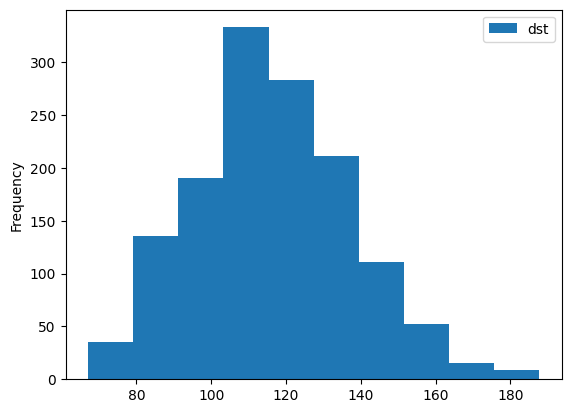

In [ ]:
df_neighbors.dst.plot(kind='hist',legend=True)